SMAI, Assignment-3, Q-4

Link of this file

https://colab.research.google.com/drive/1cE4rFTLaZSrtvJJnvMLpX9YzuILrRTco?usp=share_link

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torch
from PIL import Image
from torch import nn, save, load
from torch.optim import Adam
from torch.utils.data import DataLoader,TensorDataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms

# Q-4

## Q-4.1

### Data visualization and Preprocessing

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize((0.5,), (0.5,))])
train = datasets.MNIST(root="data", download=True, train=True, transform=transform)
print("No. of samples in dataset =",len(train.data))

100%|██████████| 9912422/9912422 [00:00<00:00, 121261480.62it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 36730046.64it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 46689246.97it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 16408724.18it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

No. of samples in dataset = 60000


### 4.1.3

 Check for any class imbalance and report.

In [ ]:
#4.1.3
data_counts = []
for i in range(10):
    data_counts.append((train.targets == i).sum())
data_counts = np.array(data_counts)
print("No. of samples distributed across data labels:",data_counts)
print("Max no. samples/Min. no of sampels =",data_counts.max()/data_counts.min())

No. of samples distributed across data labels: [5923 6742 5958 6131 5842 5421 5918 6265 5851 5949]
Max no. samples/Min. no of sampels = 1.243681977494927


The ratio of Maximum and minimum number of samples is less than 2, so the data is balanced. Also,
The graph of count vs label(4.1.1) shows that the class imbalance is not present in the data.

### 4.1.1

 Draw a graph that shows the distribution of the various labels across the
entire dataset.

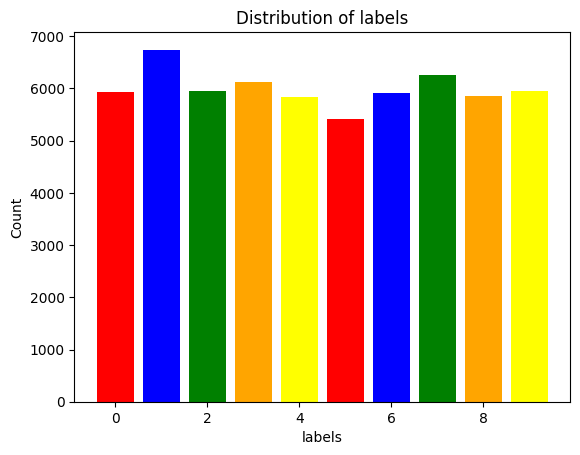

In [ ]:
colors = ['red', 'blue', 'green', 'orange','yellow','red', 'blue', 'green', 'orange','yellow']
plt.bar([0,1,2,3,4,5,6,7,8,9], data_counts, color=colors)
plt.title('Distribution of labels')
plt.xlabel('labels')
plt.ylabel('Count')
plt.show()

### 4.1.2

 Visualize several samples (say 5) of images from each class

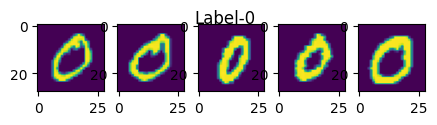

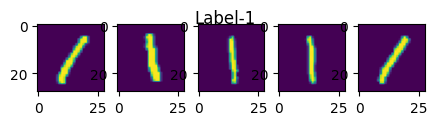

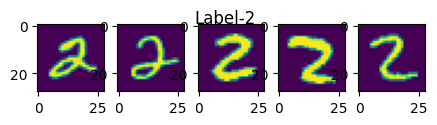

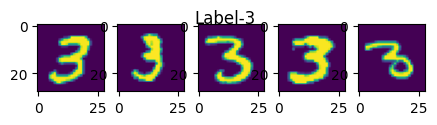

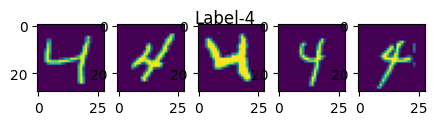

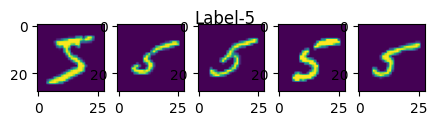

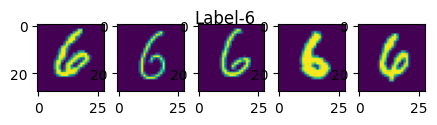

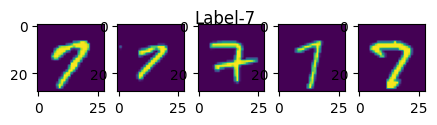

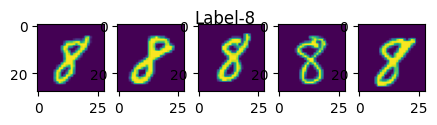

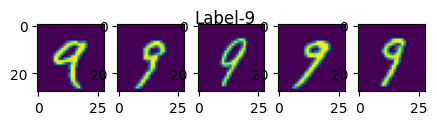

In [ ]:
X = train.data
for l in range(10):
    fig, axes = plt.subplots(1,5, figsize = (5,1))
    fig.suptitle(f"Label-{l}")
    c=0
    for i,j in enumerate(train.targets):
        if j==l:
            axes[c].imshow(X[i])
            c+=1
            if c>4:
                break

### 4.1.4

 Partition the dataset into train, validation, and test sets

In [ ]:
train_set, X_test_t = train_test_split(train,test_size=0.2,random_state=42)
valid_set, test_set = train_test_split(X_test_t,test_size=0.5,random_state=42)

### 4.1.5

Write a function to visualize the feature maps. Your code should be able
to visualize feature maps of a trained model for any layer of the given
image.

In [ ]:
#4.1.5
def plot_feature_map(sample_n, batch_size=32):
        batch_n =sample_n//batch_size
        s_n =sample_n%batch_size
        device = torch.device('cpu')
        dataloader_train = DataLoader(train_set, batch_size=batch_size, shuffle=True)

        model = MY_CNN().to(device)
        feature_map = []
        for i,(images, labels) in enumerate(dataloader_train):
                if i ==batch_n:
                        images = images.to(device)
                        labels = labels.to(device)

                        x = model.relu(model.conv1(images[s_n]))
                        feature_map.append(x)
                        x = model.pool(x)
                        feature_map.append(x)
                        x = model.relu(model.conv2(x))
                        feature_map.append(x)
                        x = model.pool(x)
                        feature_map.append(x)

        #plot the feature maps
        plot_name = np.array(['Conv-1', 'Maxpool-1','Conv-2', 'Maxpool-2'])
        for i,images in enumerate(feature_map):
                e=0
                f=0
                c = len(images)
                if c%8!=0:
                        h = (c//8)+1
                else:
                        h = c//8
                fig, axes = plt.subplots(h,8, figsize=(8,h))
                for img in images:
                        fig.suptitle(f"Layer-{plot_name[i]}")
                        axes[e][f].axis('off')
                        axes[e][f].imshow(img.detach().numpy())
                        f += 1
                        if f%8==0:
                                e+=1
                                f=0


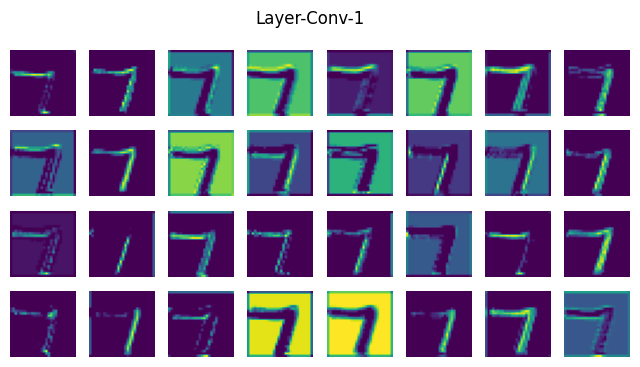

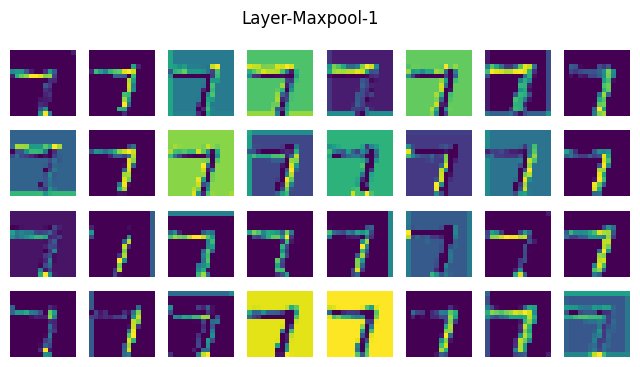

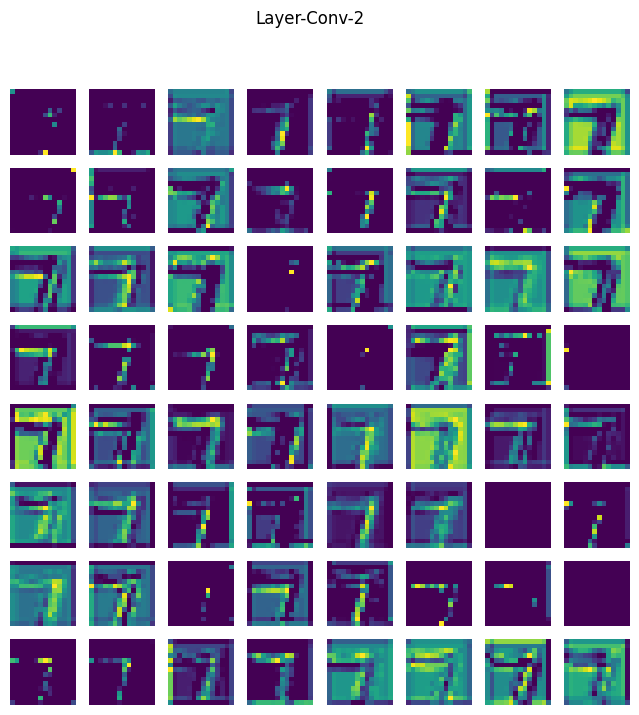

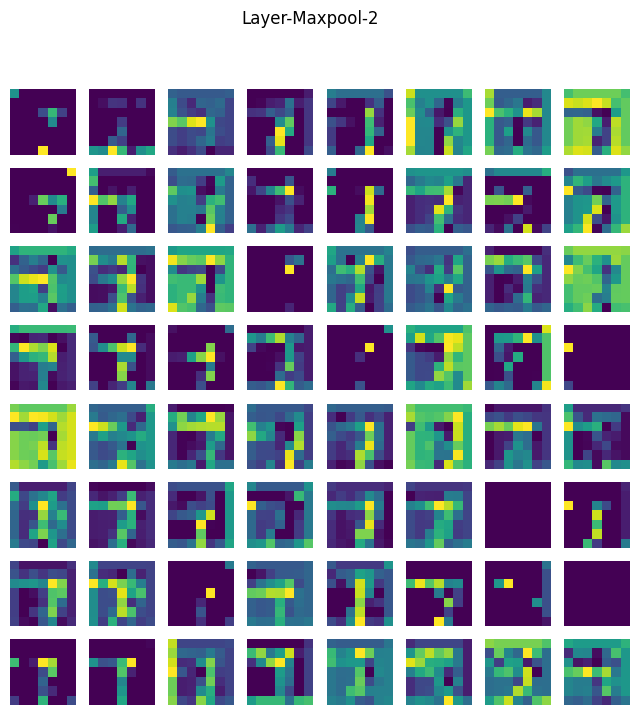

In [ ]:
plot_feature_map(sample_n = 1320, batch_size=64)


In above feature visualization as number of layer increase the feature map typically become more focused towards higher lavel or more abstract features.          
The lower lavel feature are near to the input so it's look more similar to input.           
So, we can typically divide the feature in three catagory here,            
1.lower lavel :conv-1                
2.medium lavel :Max_pool-1 and conv-2               
3.higher lavel :Max_pool-2             
              


## 4.2 CNN Model

1. Construct a CNN model for Image classification using pytorch.
2. Your network should include convolutional layers, pooling layers, dropout
layers, and fully connected layers.
3. Construct and train a baseline CNN using the following architecture: 2
convolutional layers each with ReLU activation and subsequent max pooling, followed by a dropout and a fully-connected layer with softmax activation, optimized using the Adam optimizer and trained with the crossentropy loss function.
4. Display feature maps after applying convolution and pooling layers for any
one class and provide a brief analysis.
5. Report the training and validation loss and accuracy at each epoch

In [ ]:
class MY_CNN(nn.Module):

    def __init__(self,kernel_size = (3,3),stride = (1,1), dropout_rate = 0.25):
        super(MY_CNN, self).__init__()
        self.conv1 = nn.Conv2d(1,32,kernel_size,stride=stride, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d((2,2),stride=(2,2))
        self.conv2 = nn.Conv2d(32,64,kernel_size,stride=stride, padding=1)
        # out = ((28+2-(kernel_size[0]-1)-1)/stride[0])+1   #conv1
        out1 =  int(self.calculate_out(28, kernel_size, stride)/2)
        self.out = int(self.calculate_out(out1, kernel_size, stride)/2)
        # self.out = ((out+2-(kernel_size[0]-1)-1)/stride[0])+1  #conv2
        self.dropout = nn.Dropout(dropout_rate)
        self.out_features = 64*self.out*self.out
        self.fc = nn.Linear(self.out_features,10)   #(out_features,in_features)
        self.softmax = nn.Softmax(dim=1)

    def calculate_out(self, input_size, kernel_size, stride):
            return ((input_size + 2 - (kernel_size[0] - 1) - 1) / stride[0]) + 1
    def forward(self,x):
        x = self.relu(self.conv1(x))    #N,32,28,28
        # print('1:',x.shape)
        x = self.pool(x)                #N,32,14,14
        # print('2:',x.shape)
        x = self.relu(self.conv2(x))    #N,64,14,14
        # print('3:',x.shape)
        x = self.pool(x)                #N,64,7,7
        # print('4:',x.shape)

        x = x.view(-1,self.out_features)           #N,64*7*7
        # print('5:',x.shape)

        x = self.dropout(x)             #N,64*7*7
        # print('6:',x.shape)

        x = self.fc(x)                  #N,10
        # print('7:',x.shape)

        x = self.softmax(x)
        return x


In [ ]:
def train_model(learning_rate, epochs, batch_size, kernel_size, stride, dropout_rate, test_mode=False):
    device = torch.device('cpu')
    model = MY_CNN(kernel_size, stride, dropout_rate).to(device)

    dataloader_train = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    dataloader_valid = DataLoader(valid_set, batch_size=batch_size)
    dataloader_test = DataLoader(test_set, batch_size=batch_size)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    n_total_steps = len(dataloader_train)

    for epoch in range(epochs):
        running_loss = 0.0

        for i, (images, labels) in enumerate(dataloader_train):
            images = images.to(device)
            labels = labels.to(device)
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            # Backward and optimize
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            running_loss += loss.item()

        #Accuracy calculaltion:
        with torch.no_grad():
            n_correct = 0
            if(test_mode==False):
              n_samples = len(dataloader_valid.dataset)
              for images, labels in dataloader_valid:
                  images = images.to(device)
                  labels = labels.to(device)
                  outputs = model(images)
                  # max returns (value ,index)
                  _, predicted = torch.max(outputs, axis = 1)
                  n_correct += (predicted == labels).sum().item()
            else:
              n_samples = len(dataloader_test.dataset)
              for images, labels in dataloader_test:
                  images = images.to(device)
                  labels = labels.to(device)
                  outputs = model(images)
                  # max returns (value ,index)
                  _, predicted = torch.max(outputs, axis = 1)
                  n_correct += (predicted == labels).sum().item()

            acc = 100.0 * n_correct / n_samples
        loss_ =running_loss / n_total_steps
        print(f'[{epoch + 1}] loss: {loss_:.3f}, Accuracy: {acc}')

    print('Finished Training')
    PATH = './cnn.pth'
    torch.save(model.state_dict(), PATH)
    return acc, loss_

## 4.3

4.3.1            
4.3.3

Use W&B to facilitate hyperparameter tuning. Experiment with various
architectures and hyperparameters: learning rate, batch size, kernel sizes
(filter size), strides, number of epochs, and dropout rates.

In [ ]:
!pip install wandb
import wandb
import random

# start a new wandb run to track this script
wandb.init(project="Q-4.3.1 CNN hyperparameters tunining")

from itertools import product
h_param = {
        'learning_rate': [0.005, 0.001],
        'epochs' : [4,6,8],
        'batch_size': [32,64],
        'kernel_sizes' : [(3,3),(5,5)],
        'strides' : [(1,1),(2,2)],
        'dropout_rate' : [0.15,0.25]
        }
hyper_param = list(product(*h_param.values()))
J=0
accuracy = []
for i in hyper_param:
    print(f'Hyperparameters:{J}={i}')
    acc ,loss= train_model(i[0], i[1], i[2], i[3], i[4], i[5])
    wandb.log({"Hyper parameters pair":J,"accuracy": acc, "loss": loss})
    device = torch.device('cpu')
    model = MY_CNN(i[3], i[4], i[5]).to(device)
    PATH = './cnn.pth'
    model.load_state_dict(torch.load(PATH))
    dataloader_valid = DataLoader(valid_set, batch_size=6000)
    for images, labels in dataloader_valid:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                # max returns (value ,index)
                _, predicted = torch.max(outputs, axis = 1)
    confusion = confusion_matrix(labels, predicted)
    # Log the confusion matrix to W&B
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues")
    # Log the confusion matrix image to W&B
    wandb.log({"confusion_matrix": wandb.Image(plt)})
    report = classification_report(labels, predicted, target_names=[0,1,2,3,4,5,6,7,8,9] , output_dict=True,zero_division=1.0)

# Log the class-specific metrics to W&B
    for class_name, metrics in report.items():
        if class_name != 'accuracy':  # Skip the 'accuracy' key
            wandb.log({f"{class_name}_precision": metrics["precision"], f"{class_name}_recall": metrics["recall"], f"{class_name}_f1": metrics["f1-score"]})

    J += 1
    accuracy.append(acc)
wandb.finish()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.0/241.0 kB 21.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.2 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=eebeadacb8478637cc8c7cf5fe38d90f38431ab925d318171a709020fbb9271b
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Hyperparameters:0=(0.005, 4, 32, (3, 3), (1, 1), 0.15)
[1] loss: 1.639, Accuracy: 86.56666666666666
[2] loss: 1.602, Accuracy: 86.13333333333334
[3] loss: 1.588, Accuracy: 95.08333333333333
[4] loss: 1.517, Accuracy: 93.95
Finished Training
Hyperparameters:1=(0.005, 4, 32, (3, 3), (1, 1), 0.25)
[1] loss: 1.746, Accuracy: 76.75
[2] loss: 1.700, Accuracy: 76.06666666666666
[3] loss: 1.702, Accuracy: 76.73333333333333
[4] loss: 1.705, Accuracy: 76.03333333333333
Finished Training
Hyperparameters:2=(0.005, 4, 32, (3, 3), (2, 2), 0.15)
[1] loss: 1.593, Accuracy: 93.93333333333334
[2] loss: 1.510, Accuracy: 95.66666666666667
[3] loss: 1.508, Accuracy: 96.11666666666666
[4] loss: 1.508, Accuracy: 95.2
Finished Training
Hyperparameters:3=(0.005, 4, 32, (3, 3), (2, 2), 0.25)
[1] loss: 1.725, Accuracy: 83.9
[2] loss: 1.612, Accuracy: 86.31666666666666
[3] loss: 1.606, Accuracy: 86.11666666666666
[4] loss: 1.602, Accuracy: 86.41666666666667
Finished Training
Hyperparameters:4=(0.005, 4, 32, (5, 5

<ipython-input-65-fea0cda83dd6>:37: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8, 6))


Hyperparameters:21=(0.005, 6, 32, (5, 5), (1, 1), 0.25)
[1] loss: 2.358, Accuracy: 10.6
[2] loss: 2.358, Accuracy: 10.6
[3] loss: 2.358, Accuracy: 10.6
[4] loss: 2.358, Accuracy: 10.6
[5] loss: 2.358, Accuracy: 10.6
[6] loss: 2.358, Accuracy: 10.6
Finished Training
Hyperparameters:22=(0.005, 6, 32, (5, 5), (2, 2), 0.15)
[1] loss: 1.619, Accuracy: 91.68333333333334
[2] loss: 1.521, Accuracy: 92.66666666666667
[3] loss: 1.515, Accuracy: 94.23333333333333
[4] loss: 1.515, Accuracy: 94.78333333333333
[5] loss: 1.514, Accuracy: 94.8
[6] loss: 1.510, Accuracy: 95.18333333333334
Finished Training
Hyperparameters:23=(0.005, 6, 32, (5, 5), (2, 2), 0.25)
[1] loss: 1.630, Accuracy: 91.01666666666667
[2] loss: 1.530, Accuracy: 93.41666666666667
[3] loss: 1.520, Accuracy: 94.1
[4] loss: 1.518, Accuracy: 93.68333333333334
[5] loss: 1.520, Accuracy: 92.98333333333333
[6] loss: 1.518, Accuracy: 94.26666666666667
Finished Training
Hyperparameters:24=(0.005, 6, 64, (3, 3), (1, 1), 0.15)
[1] loss: 1.612,

In [ ]:
Max_accu_hy_param_index = 56
Max_accu_hy_param_index = np.argmax(accuracy)
print(f"We get this accuracy for this hyperparameters\n(learning_rate,epochs,batch_size,kernel_sizes,strides,dropout_rate): {hyper_param[Max_accu_hy_param_index]}.")
# print(f"The maximum accuracy{Max_accu_hy_param_index} = {accuracy[Max_accu_hy_param_index]} \nWe get this accuracy for this hyperparameters\n(learning_rate,epochs,batch_size,kernel_sizes,strides,dropout_rate): {hyper_param[Max_accu_hy_param_index]}.")

The max accuracy is 98.5%.(Information collected from wandb report) at 56th hyperparameter.

In [ ]:

from itertools import product
h_param = {
        'learning_rate': [0.005, 0.001],
        'epochs' : [4,6,8],
        'batch_size': [32,64],
        'kernel_sizes' : [(3,3),(5,5)],
        'strides' : [(1,1),(2,2)],
        'dropout_rate' : [0.15,0.25]
        }
hyper_param = list(product(*h_param.values()))

### 4.3.2

 Compare the effect of using and not using dropout layers.

In [ ]:
# Max_accu_hy_param_index = 56
i = hyper_param[Max_accu_hy_param_index]
device = torch.device('cpu')
model = MY_CNN(i[3], i[4], i[5]).to(device)
PATH = './cnn.pth'
dataloader_train = DataLoader(train_set, batch_size=6000)

print("Model with dropout layer:")
print('Hyperparameters',i[0], i[1], i[2], i[3], i[4], 0.25)
acc ,loss= train_model(i[0], i[1], i[2], i[3], i[4], 0.25)
# i[5] = 0.0    #making dropout ratio zero

model.load_state_dict(torch.load(PATH))
n_samples = len(dataloader_train.dataset)
n_correct=0
for images, labels in dataloader_train:
  images = images.to(device)
  labels = labels.to(device)
  outputs = model(images)
  _, predicted = torch.max(outputs, axis = 1)
  n_correct += (predicted == labels).sum().item()
print('Accuracy on train dataset',100.0 * n_correct / n_samples)

print("\nModel without dropout layer:")
print('Hyperparameters',i[0], i[1], i[2], i[3], i[4], 0.0)
acc ,loss= train_model(i[0], i[1], i[2], i[3], i[4], 0)

model.load_state_dict(torch.load(PATH))
n_samples = len(dataloader_train.dataset)
n_correct=0
for images, labels in dataloader_train:
  images = images.to(device)
  labels = labels.to(device)
  outputs = model(images)
  _, predicted = torch.max(outputs, axis = 1)
  n_correct += (predicted == labels).sum().item()
print('Accuracy on train dataset',100.0 * n_correct / n_samples)


Model with dropout layer:
Hyperparameters 0.001 4 64 (3, 3) (1, 1) 0.25
[1] loss: 1.619, Accuracy: 96.83333333333333
[2] loss: 1.489, Accuracy: 98.13333333333334
[3] loss: 1.483, Accuracy: 97.86666666666666
[4] loss: 1.480, Accuracy: 98.05
Finished Training
Accuracy on train dataset 98.51666666666667
Model without dropout layer:
Hyperparameters 0.001 4 64 (3, 3) (1, 1) 0.0
[1] loss: 1.601, Accuracy: 97.75
[2] loss: 1.486, Accuracy: 98.08333333333333
[3] loss: 1.480, Accuracy: 98.55
[4] loss: 1.477, Accuracy: 98.3
Finished Training
Accuracy on train dataset 98.6



For model without dropout the train accuarcy is increased which is the sign of overfitting.

## 4.4

1. Evaluate your best model on the test set and report accuracy, per-class
accuracy, and classification report.
2. Provide a clear visualization of the model’s performance, e.g., confusion
matrix
3. Identify a few instances where the model makes incorrect predictions and
analyze possible reasons behind these misclassifications.

In [ ]:
i = hyper_param[Max_accu_hy_param_index]
# print("classification report for the best accuracy model")
print("Model with dropout layer:")
print('Hyperparameters',i)
acc ,loss= train_model(i[0], i[1], i[2], i[3], i[4], i[5],test_mode=True)

Model with dropout layer:
Hyperparameters (0.001, 4, 64, (3, 3), (1, 1), 0.15)
[1] loss: 1.546, Accuracy: 96.75
[2] loss: 1.488, Accuracy: 98.15
[3] loss: 1.482, Accuracy: 97.88333333333334
[4] loss: 1.478, Accuracy: 97.95
Finished Training


,precision,recall,f1-score,support,Labels_Accuracy
0,0.985173,0.990066,0.987614,604.000000,0.990066
1,1.000000,0.985938,0.992919,640.000000,0.985938
2,0.974729,0.981818,0.978261,550.000000,0.981818
3,0.998331,0.967638,0.982744,618.000000,0.967638
4,0.975450,0.996656,0.985939,598.000000,0.996656
5,0.996198,0.939068,0.966790,558.000000,0.939068
6,0.988411,0.986777,0.987593,605.000000,0.986777
7,0.978723,0.971342,0.975019,663.000000,0.971342
8,0.898876,0.991150,0.942761,565.000000,0.991150
9,0.989779,0.969950,0.979764,599.000000,0.969950


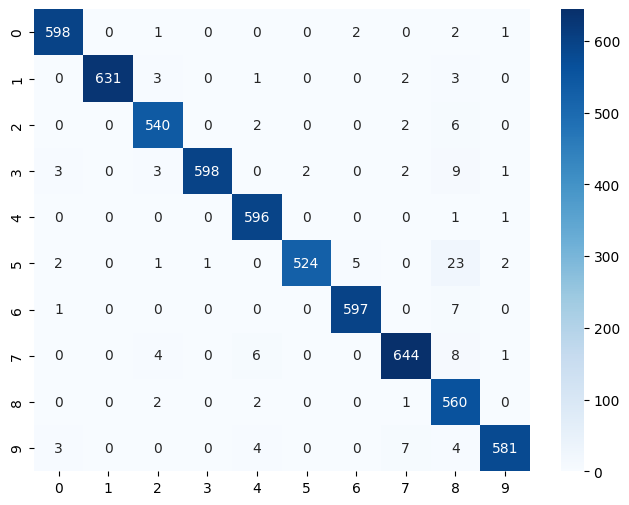

In [ ]:
#classifiction report on test dataset
device = torch.device('cpu')
model = MY_CNN(i[3], i[4], i[5]).to(device)
PATH = './cnn.pth'
model.load_state_dict(torch.load(PATH))
dataloader_test = DataLoader(test_set, batch_size=6000)
for images, labels in dataloader_test:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            # max returns (value ,index)
            _, predicted = torch.max(outputs, axis = 1)
confusion = confusion_matrix(labels, predicted)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues")
#label accuracy calculation
target_names=[0,1,2,3,4,5,6,7,8,9]
acc= []
for j in target_names:
  # c = torch.logical_and(labels==predicted),(labels==j)
  a = ((labels==predicted)&(labels==j)).sum().item()/(labels==j).sum().item()
  acc.append(a)
report = classification_report(labels, predicted, target_names=[0,1,2,3,4,5,6,7,8,9] , output_dict=True,zero_division=1.0)
df_classification_report = pd.DataFrame(report).transpose()
acc.append(0)
acc.append(0)
acc.append(0)
df_classification_report['Labels_Accuracy'] = acc
df_classification_report

### 4.4.3
Major miss prediction is between(7&2,9&4,9&7,5&8).   
Which is due to the similarity between those digits. So, the model confuse between those digits.

## 4.5

 ### Train on Noisy Dataset

### 4.5.1, 4.5.2

1. Train your best model from the previous parts of Task 4 on the noisy
mnist dataset which contains noise in it (additive white gaussian noise,
don’t worry it’s just a fancy name).          
2. Report validation losses, validation scores, training losses, training scores


In [ ]:
import scipy.io as sio
from torch.utils.data import DataLoader,TensorDataset
mat_contents = sio.loadmat('/content/drive/MyDrive/SMAI_Google colab/mnist-with-awgn.mat')

In [ ]:
train_x = mat_contents['train_x']
train_y = mat_contents['train_y']
test_x = mat_contents['test_x']
test_y = mat_contents['test_y']
print('train_x shape',train_x.shape,'\ntest_x shape',test_x.shape,'\ntrain_y shape',train_y.shape,'\ntest_y shape',test_y.shape)

train_x shape (60000, 784) 
test_x shape (10000, 784) 
train_y shape (60000, 10) 
test_y shape (10000, 10)


In [ ]:
train_x_n = train_x.astype('float32')  /255.0
train_x_n = train_x_n.reshape(train_x.shape[0], 1, 28, 28)
test_x_n = test_x.astype('float32') /255.0
test_x_n = test_x_n.reshape(test_x.shape[0], 1, 28, 28)
train_x_n = torch.from_numpy(train_x_n)
test_x_n = torch.from_numpy(test_x_n)
train_y_n = torch.from_numpy(train_y)
test_y_n = torch.from_numpy(test_y)
train_set = TensorDataset(train_x_n, train_y_n.type(torch.float32))

In [ ]:
def train_model(learning_rate, epochs, batch_size, kernel_size, stride, dropout_rate):
    device = torch.device('cpu')
    model = MY_CNN(kernel_size, stride, dropout_rate).to(device)

    dataloader_train = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    dataloader_valid = DataLoader(valid_set, batch_size=batch_size)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    n_total_steps = len(dataloader_train)

    for epoch in range(epochs):
        running_loss = 0.0

        for i, (images, labels) in enumerate(dataloader_train):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            running_loss += loss.item()

        #Accuracy calculaltion:
        with torch.no_grad():
            n_correct = 0
            n_samples = len(dataloader_valid.dataset)

            for images, labels in dataloader_valid:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                # max returns (value ,index)
                _, predicted = torch.max(outputs, axis = 1)
                # _, labels = torch.max(labels, axis = 1)
                # print(labels.shape,predicted.shape)
                n_correct += (predicted == labels).sum().item()

            acc = 100.0 * n_correct / n_samples
        loss_ =running_loss / n_total_steps
        print(f'[{epoch + 1}] loss: {loss_:.3f}, Valid_set_Accuracy: {acc}')

    print('Finished Training')
    PATH = './cnn.pth'
    torch.save(model.state_dict(), PATH)
    return acc, loss_

In [ ]:

from itertools import product
h_param = {
        'learning_rate': [0.005, 0.001],
        'epochs' : [4,6,8],
        'batch_size': [32,64],
        'kernel_sizes' : [(3,3),(5,5)],
        'strides' : [(1,1),(2,2)],
        'dropout_rate' : [0.15,0.25]
        }
hyper_param = list(product(*h_param.values()))

In [ ]:
i = hyper_param[Max_accu_hy_param_index]
print('Hyperparameters',i)
acc ,loss= train_model(i[0], i[1], i[2], i[3], i[4], i[5])

Model with dropout layer:
Hyperparameters (0.001, 4, 64, (3, 3), (1, 1), 0.15)
[1] loss: 1.608, Valid_set_Accuracy: 90.7
[2] loss: 1.504, Valid_set_Accuracy: 93.16666666666667
[3] loss: 1.495, Valid_set_Accuracy: 95.23333333333333
[4] loss: 1.491, Valid_set_Accuracy: 94.63333333333334
Finished Training


### 4.5.3

3. Evaluate your model on test data and print the classification report.

In [ ]:
device = torch.device('cpu')
model = MY_CNN(i[3], i[4], i[5]).to(device)
PATH = './cnn.pth'
model.load_state_dict(torch.load(PATH))
dataloader_test = DataLoader(test_set, batch_size=6000)
n_samples = len(dataloader_test.dataset)
n_correct=0
for images, labels in dataloader_test:
  images = images.to(device)
  labels = labels.to(device)
  outputs = model(images)
  # max returns (value ,index)
  _, predicted = torch.max(outputs, axis = 1)
  # _, labels = torch.max(labels, axis = 1)
  # print(labels.shape,predicted.shape)
  n_correct += (predicted == labels).sum().item()
print('Accuracy',100.0 * n_correct / n_samples)

Accuracy 94.76666666666667


,precision,recall,f1-score,support,Labels_Accuracy
0,0.994783,0.947020,0.970314,604.000000,0.947020
1,0.963190,0.981250,0.972136,640.000000,0.981250
2,0.855346,0.989091,0.917369,550.000000,0.989091
3,0.956592,0.962783,0.959677,618.000000,0.962783
4,0.987455,0.921405,0.953287,598.000000,0.921405
5,0.938918,0.964158,0.951370,558.000000,0.964158
6,0.986509,0.966942,0.976628,605.000000,0.966942
7,0.946188,0.954751,0.950450,663.000000,0.954751
8,0.979296,0.837168,0.902672,565.000000,0.837168
9,0.887324,0.946578,0.915994,599.000000,0.946578


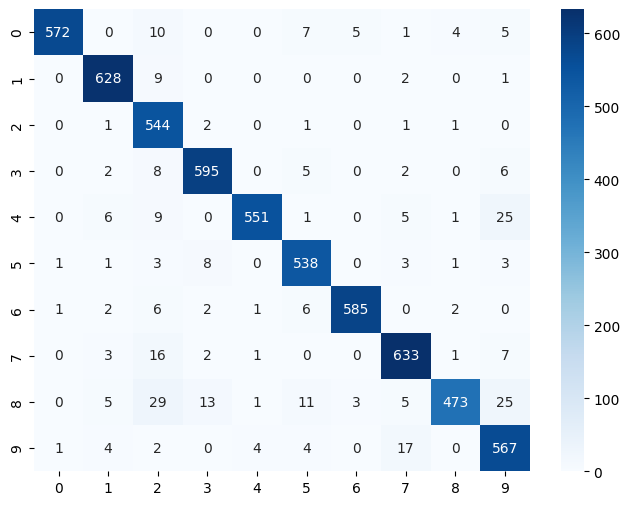

In [ ]:
confusion = confusion_matrix(labels, predicted)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues")
#label accuracy calculation
target_names=[0,1,2,3,4,5,6,7,8,9]
acc= []
for j in target_names:
  # c = torch.logical_and(labels==predicted),(labels==j)
  a = ((labels==predicted)&(labels==j)).sum().item()/(labels==j).sum().item()
  acc.append(a)
report = classification_report(labels, predicted, target_names=[0,1,2,3,4,5,6,7,8,9] , output_dict=True,zero_division=1.0)
df_classification_report = pd.DataFrame(report).transpose()
acc.append(0)
acc.append(0)
acc.append(0)
df_classification_report['Labels_Accuracy'] = acc
df_classification_report

## 4.6

1. Implement an Autoencoder class which will help you de-noise the noisy
mnist dataset from Part 4.5.

In [ ]:
#Autoencoder
class MY_AE(torch.nn.Module):
  def __init__(self):
    super(MY_AE,self).__init__()
    self.dropout = nn.Dropout(0.20)
    self.encoder = torch.nn.Sequential(
        nn.Conv2d(1,16,3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2),
        nn.Conv2d(16,4,3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2)
    )
    self.decoder = torch.nn.Sequential(
        nn.ConvTranspose2d(4,16, kernel_size=2, stride=2),
        nn.ReLU(),
        nn.ConvTranspose2d(16, 1,kernel_size=2, stride=2),
        nn.Sigmoid()
    )

  def forward(self,x):

    x = self.encoder(x)
    # print("encoder shape:",x.shape)
    x = self.decoder(x)
    # print("decoder shape:",x.shape)
    return x

In [ ]:
#import the dataset to train the Autoencoder
transform = transforms.Compose([transforms.ToTensor(),
                                #AddNoise(noise_factor=0.1),
                                        #transforms.Normalize((0.5,), (0.5,))
                                        ])
train = datasets.MNIST(root="data", download=True, train=True, transform=transform)

print("No. of samples in dataset =",len(train.data))
train_set, X_test_t = train_test_split(train,test_size=0.2,random_state=42)
valid_set, test_set = train_test_split(X_test_t,test_size=0.5,random_state=42)

100%|██████████| 9912422/9912422 [00:00<00:00, 99788093.42it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 3771700.15it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 30232612.03it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 14918190.11it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



No. of samples in dataset = 60000


In [ ]:
#train the autoencoder using data+noise
batch_size = 64
learning_rate = 0.001
epochs = 15
model = MY_AE()
dataloader_train = DataLoader(train_set, batch_size=batch_size)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_loss=0
noise_factor = 0.5
# Train the autoencoder
for epoch in range(epochs):
    for data in dataloader_train:
        img, _ = data
       #inserting the noise in the data
        noisy_imgs = img + noise_factor * torch.randn(*img.shape)
        optimizer.zero_grad()
        output = model(noisy_imgs)
        loss = criterion(output, img)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*img.size(0)

    train_loss = train_loss/len(dataloader_train)
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, train_loss))

# Save the model
torch.save(model.state_dict(), 'conv_autoencoder.pth')


Epoch [1/15], Loss: 4.1781
Epoch [2/15], Loss: 1.9145
Epoch [3/15], Loss: 1.7394
Epoch [4/15], Loss: 1.6245
Epoch [5/15], Loss: 1.5721
Epoch [6/15], Loss: 1.5403
Epoch [7/15], Loss: 1.5178
Epoch [8/15], Loss: 1.4997
Epoch [9/15], Loss: 1.4819
Epoch [10/15], Loss: 1.4689
Epoch [11/15], Loss: 1.4556
Epoch [12/15], Loss: 1.4477
Epoch [13/15], Loss: 1.4430
Epoch [14/15], Loss: 1.4372
Epoch [15/15], Loss: 1.4344


### 4.6.2

Visualise the classes and feature space before and after de-noising.

In [ ]:
#Given noisiy dataset
import scipy.io as sio
mat_contents = sio.loadmat('/content/drive/MyDrive/SMAI_Google colab/mnist-with-awgn.mat')
train_x = mat_contents['train_x']
train_y = mat_contents['train_y']
print('train_x shape:',train_x.shape,'\ntrain_y shape:',train_y.shape)

train_x shape: (60000, 784) 
train_y shape: (60000, 10)


In [ ]:
#preprocessing of the dataset
train_x_n = train_x.astype('float32')  /255.0
train_x_n = train_x_n.reshape(train_x.shape[0], 1, 28, 28)
train_x_n = torch.from_numpy(train_x_n)
train_y_n = torch.from_numpy(train_y)
train_set_with_noise = TensorDataset(train_x_n, train_y_n.type(torch.float32))

In [ ]:
#remove the noise from data
from scipy.io import savemat
model.eval()
dataloader_test = DataLoader(train_set_with_noise, batch_size=6000, shuffle=False)
denoised_imgs = []
img_labels = []
with torch.no_grad():
  for img, labels in dataloader_test:
    d_imgs = model(img)
    denoised_imgs.append(d_imgs.cpu().numpy())
    img_labels.append(labels.cpu().numpy())
denoised_imgs = np.concatenate(denoised_imgs,axis=0)
img_labels = np.concatenate(img_labels,axis=0)
savemat('denoised_train_mat',{"X":denoised_imgs,"Y":img_labels})

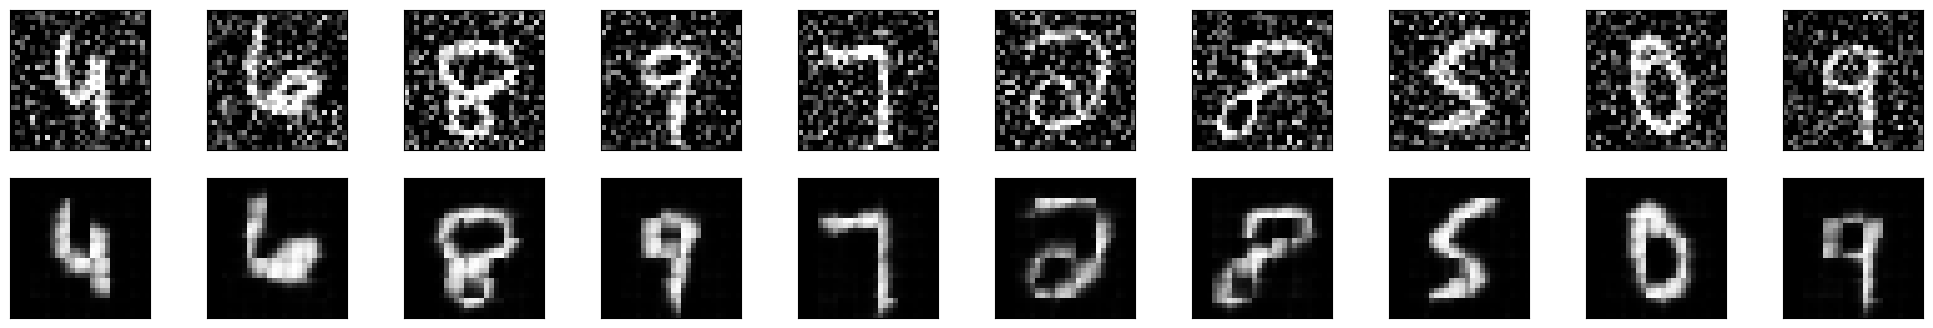

In [ ]:
#visulize the dataset samples with and without noise
dataloader_test = DataLoader(train_set_with_noise, batch_size=64, shuffle=False)
dataiter = iter(dataloader_test)

with torch.no_grad():
  for images, labels in dataiter:
    break
  output = model(images)
images = images.numpy()

output = output.view(batch_size, 1, 28, 28)
output = output.detach().numpy()
#This code for visulization is generated by chat gpt:start
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        #End

### 4.6.3

Now using the de-noised dataset, train your best model from the previous
parts

In [ ]:
#import the data denoised in the previous stage
train_set_without_noise_n = sio.loadmat("denoised_train_mat")
X = train_set_without_noise_n['X']
Y = train_set_without_noise_n['Y']
train_x_n = torch.from_numpy(X)
train_y_n = torch.from_numpy(Y)
train_set_without_noise = TensorDataset(train_x_n, train_y_n.type(torch.float32))

In [ ]:
def train_model(learning_rate, epochs, batch_size, kernel_size, stride, dropout_rate, test_mode=False):
    device = torch.device('cpu')
    model = MY_CNN(kernel_size, stride, dropout_rate).to(device)

    dataloader_train = DataLoader(train_set_without_noise, batch_size=batch_size, shuffle=True)
    dataloader_valid = DataLoader(valid_set, batch_size=batch_size)
    dataloader_test = DataLoader(test_set, batch_size=batch_size)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    n_total_steps = len(dataloader_train)

    for epoch in range(epochs):
        running_loss = 0.0

        for i, (images, labels) in enumerate(dataloader_train):
            images = images.to(device)
            labels = labels.to(device)
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            # Backward and optimize
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            running_loss += loss.item()

        #Accuracy calculaltion:
        with torch.no_grad():
            n_correct = 0
            if(test_mode==False):
              n_samples = len(dataloader_valid.dataset)
              for images, labels in dataloader_valid:
                  images = images.to(device)
                  labels = labels.to(device)
                  outputs = model(images)
                  # max returns (value ,index)
                  _, predicted = torch.max(outputs, axis = 1)
                  n_correct += (predicted == labels).sum().item()
            else:
              n_samples = len(dataloader_test.dataset)
              for images, labels in dataloader_test:
                  images = images.to(device)
                  labels = labels.to(device)
                  outputs = model(images)
                  # max returns (value ,index)
                  _, predicted = torch.max(outputs, axis = 1)
                  n_correct += (predicted == labels).sum().item()

            acc = 100.0 * n_correct / n_samples
        loss_ =running_loss / n_total_steps
        print(f'[{epoch + 1}] loss: {loss_:.3f}, Accuracy: {acc}')

    print('Finished Training')
    PATH = './cnn.pth'
    torch.save(model.state_dict(), PATH)
    return acc, loss_

In [ ]:
from itertools import product
h_param = {
        'learning_rate': [0.005, 0.001],
        'epochs' : [4,6,8],
        'batch_size': [32,64],
        'kernel_sizes' : [(3,3),(5,5)],
        'strides' : [(1,1),(2,2)],
        'dropout_rate' : [0.15,0.25]
        }

hyper_param = list(product(*h_param.values()))
Max_accu_hy_param_index=56
i = hyper_param[Max_accu_hy_param_index]
# print("classification report for the best accuracy model")
print("Valid accuracy of the model for best hyperparameters:")
print('Hyperparameters',i)
acc ,loss= train_model(i[0], i[1], i[2], i[3], i[4], i[5])

Valid accuracy of the model for best hyperparameters:
Hyperparameters (0.001, 4, 64, (3, 3), (1, 1), 0.15)
[1] loss: 1.616, Accuracy: 95.75
[2] loss: 1.519, Accuracy: 96.63333333333334
[3] loss: 1.510, Accuracy: 96.75
[4] loss: 1.505, Accuracy: 97.4
Finished Training


### 4.6.4, 4.6.5

4. Report validation losses, validation scores, training losses, training scores.
5. Evaluate your model on test data and print the classification report.

In [ ]:
device = torch.device('cpu')
model = MY_CNN(i[3], i[4], i[5]).to(device)
PATH = './cnn.pth'
model.load_state_dict(torch.load(PATH))
dataloader_test = DataLoader(test_set, batch_size=6000)
n_samples = len(dataloader_test.dataset)
n_correct=0
for images, labels in dataloader_test:
  images = images.to(device)
  labels = labels.to(device)
  outputs = model(images)
  # max returns (value ,index)
  _, predicted = torch.max(outputs, axis = 1)
  # _, labels = torch.max(labels, axis = 1)
  # print(labels.shape,predicted.shape)
  n_correct += (predicted == labels).sum().item()
print('Accuracy',100.0 * n_correct / n_samples)

Accuracy 97.18333333333334


,precision,recall,f1-score,support,Labels_Accuracy
0,0.983471,0.985099,0.984285,604.000000,0.985099
1,0.998395,0.971875,0.984956,640.000000,0.971875
2,0.964286,0.981818,0.972973,550.000000,0.981818
3,0.974110,0.974110,0.974110,618.000000,0.974110
4,0.986486,0.976589,0.981513,598.000000,0.976589
5,0.966132,0.971326,0.968722,558.000000,0.971326
6,0.964516,0.988430,0.976327,605.000000,0.988430
7,0.954142,0.972851,0.963406,663.000000,0.972851
8,0.963834,0.943363,0.953488,565.000000,0.943363
9,0.962838,0.951586,0.957179,599.000000,0.951586


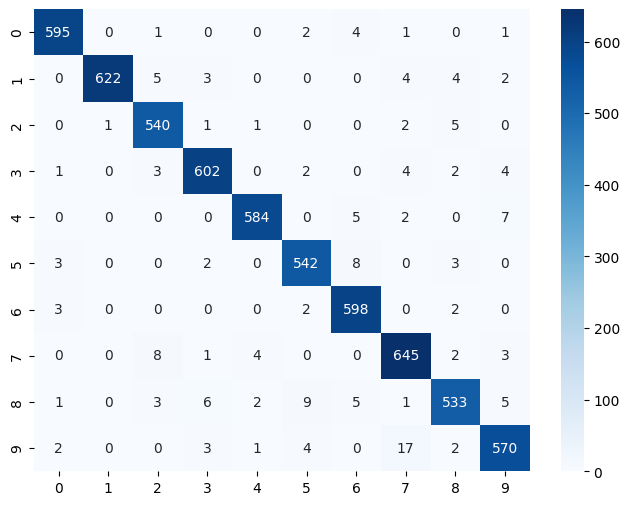

In [ ]:
confusion = confusion_matrix(labels, predicted)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues")
#label accuracy calculation
target_names=[0,1,2,3,4,5,6,7,8,9]
acc= []
for j in target_names:
  # c = torch.logical_and(labels==predicted),(labels==j)
  a = ((labels==predicted)&(labels==j)).sum().item()/(labels==j).sum().item()
  acc.append(a)
report = classification_report(labels, predicted, target_names=[0,1,2,3,4,5,6,7,8,9] , output_dict=True,zero_division=1.0)
df_classification_report = pd.DataFrame(report).transpose()
acc.append(0)
acc.append(0)
acc.append(0)
df_classification_report['Labels_Accuracy'] = acc
df_classification_report

### 4.6.6

Analyse and compare the results/accuracy scores as obtained in Part 4.5
and 4.6

The accuracy for with noise dataset is 94.7% and for the without noise dataset 97.2%. For other paramers also have the 2to3% diffrence between both model results. which shows that the model of autoencoder performed the denoising task correctly.